In [1]:
#Import the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
!pip install pandas matplotlib seaborn

In [4]:
data = pd.read_csv("/kaggle/input/customer-churn-prediction-dataset/Churn_Modelling.csv")

In [5]:
print(data)

      RowNumber  CustomerId    Surname  CreditScore Geography  Gender  Age  \
0             1    15634602   Hargrave          619    France  Female   42   
1             2    15647311       Hill          608     Spain  Female   41   
2             3    15619304       Onio          502    France  Female   42   
3             4    15701354       Boni          699    France  Female   39   
4             5    15737888   Mitchell          850     Spain  Female   43   
...         ...         ...        ...          ...       ...     ...  ...   
9995       9996    15606229   Obijiaku          771    France    Male   39   
9996       9997    15569892  Johnstone          516    France    Male   35   
9997       9998    15584532        Liu          709    France  Female   36   
9998       9999    15682355  Sabbatini          772   Germany    Male   42   
9999      10000    15628319     Walker          792    France  Female   28   

      Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMemb

In [6]:
print(data.columns)

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')


In [7]:
#If any columns has zero
print(data.isnull().sum())

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


In [8]:
#Drop the irrelevant columns
data.drop(columns=["RowNumber","CustomerId","Surname"],inplace=True)

In [9]:
print(data.columns)

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')


In [10]:
# Encode categorical features
le_gender = LabelEncoder()
le_geo = LabelEncoder()

data["Gender"] = le_gender.fit_transform(data["Gender"])      # Female:0, Male:1
data["Geography"] = le_geo.fit_transform(data["Geography"])   # France/Spain/Germany -> 0/1/


In [11]:
# Define features (X) and target (y)
X = data.drop('Exited', axis=1)
y = data['Exited']

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
# Train XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [13]:
# Predictions
y_pred = xgb.predict(X_test_scaled)
y_proba = xgb.predict_proba(X_test_scaled)[:, 1]

In [14]:
# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.95      0.91      1593
           1       0.68      0.46      0.55       407

    accuracy                           0.85      2000
   macro avg       0.78      0.70      0.73      2000
weighted avg       0.83      0.85      0.84      2000

ROC AUC Score: 0.8305238983205085


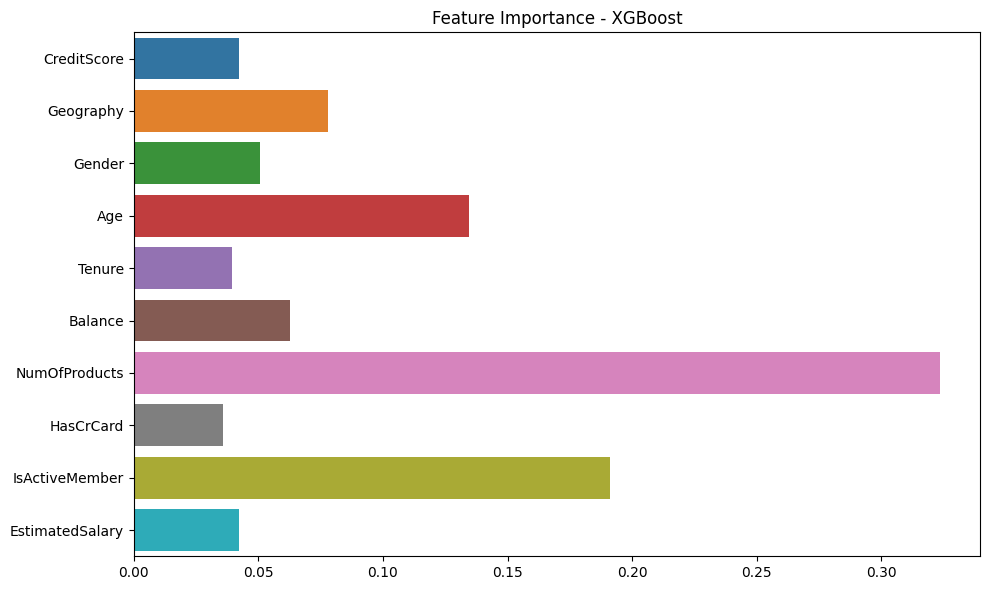

In [15]:
#Feature Importance Plot
importances = xgb.feature_importances_
features = X.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance - XGBoost")
plt.tight_layout()
plt.show()

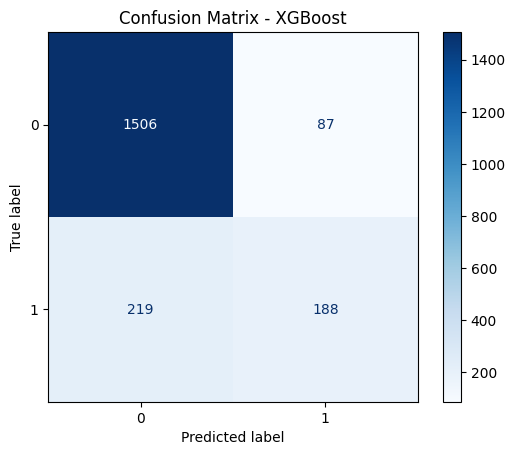

In [16]:
#Confusion Matrix
ConfusionMatrixDisplay.from_estimator(xgb, X_test_scaled, y_test, cmap="Blues")
plt.title("Confusion Matrix - XGBoost")
plt.show()

In [20]:
#Save predictions for reporting (e.g., Power BI)
pred_df = X_test.copy()
pred_df["Actual_Churn"] = y_test.values
pred_df["Predicted_Churn"] = y_pred
pred_df["Churn_Probability"] = y_proba
pred_df.to_csv("xgboost_churn_predictions.csv", index=False)

print("✅ Prediction results saved to: xgboost_churn_predictions.csv")

✅ Prediction results saved to: xgboost_churn_predictions.csv


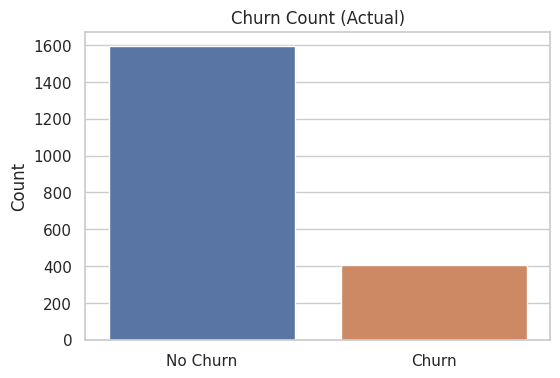

In [21]:
#For the visualization purpose
# Load dataset
df = pd.read_csv("/kaggle/working/xgboost_churn_predictions.csv")

# Optional: decode categorical values if needed
geography_map = {0: "France", 1: "Germany", 2: "Spain"}
gender_map = {0: "Female", 1: "Male"}
df["Geography"] = df["Geography"].map(geography_map)
df["Gender"] = df["Gender"].map(gender_map)

# Set style
sns.set(style="whitegrid")

# 1. Churn Distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="Actual_Churn")
plt.title("Churn Count (Actual)")
plt.xticks([0, 1], ['No Churn', 'Churn'])
plt.xlabel("")
plt.ylabel("Count")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


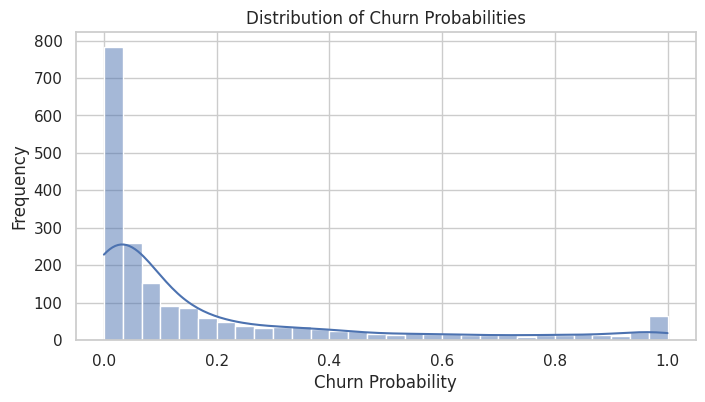

In [24]:
# 2. Churn Probability Distribution
plt.figure(figsize=(8, 4))
sns.histplot(df["Churn_Probability"], bins=30, kde=True)
plt.title("Distribution of Churn Probabilities")
plt.xlabel("Churn Probability")
plt.ylabel("Frequency")
plt.show()

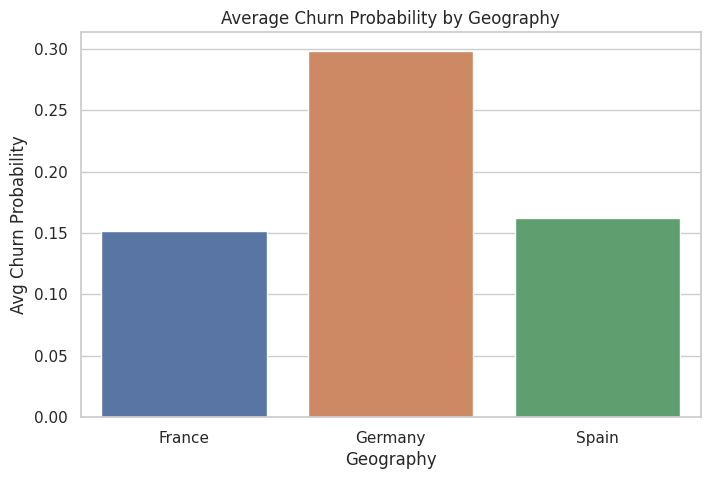

In [25]:
# 3. Average Churn Probability by Geography
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x="Geography", y="Churn_Probability", errorbar=None)
plt.title("Average Churn Probability by Geography")
plt.ylabel("Avg Churn Probability")
plt.xlabel("Geography")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


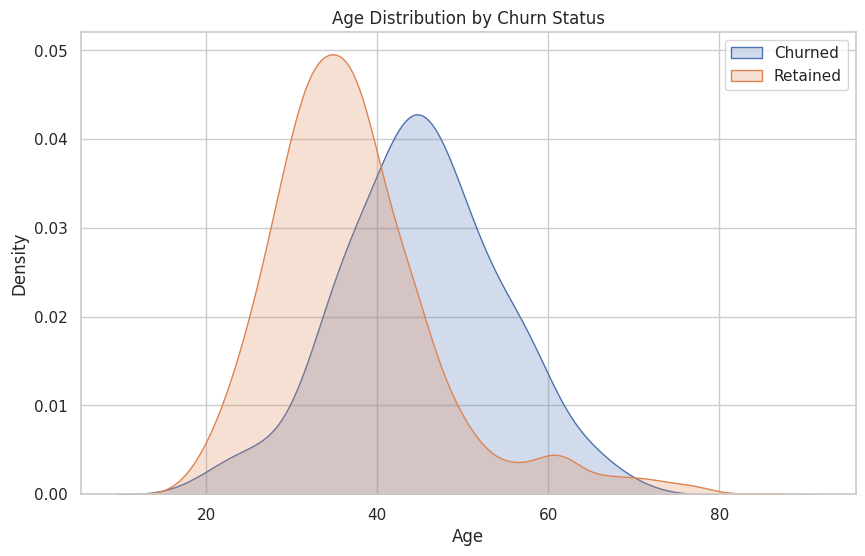

In [26]:
# 4. Churn Rate by Age
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df[df["Actual_Churn"] == 1], x="Age", label="Churned", fill=True)
sns.kdeplot(data=df[df["Actual_Churn"] == 0], x="Age", label="Retained", fill=True)
plt.title("Age Distribution by Churn Status")
plt.xlabel("Age")
plt.ylabel("Density")
plt.legend()
plt.show()

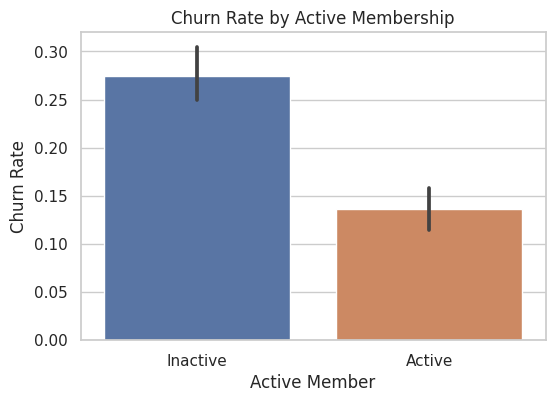

In [27]:
# 5. Churn Rate by IsActiveMember
plt.figure(figsize=(6, 4))
sns.barplot(data=df, x="IsActiveMember", y="Actual_Churn")
plt.title("Churn Rate by Active Membership")
plt.xticks([0, 1], ['Inactive', 'Active'])
plt.ylabel("Churn Rate")
plt.xlabel("Active Member")
plt.show()

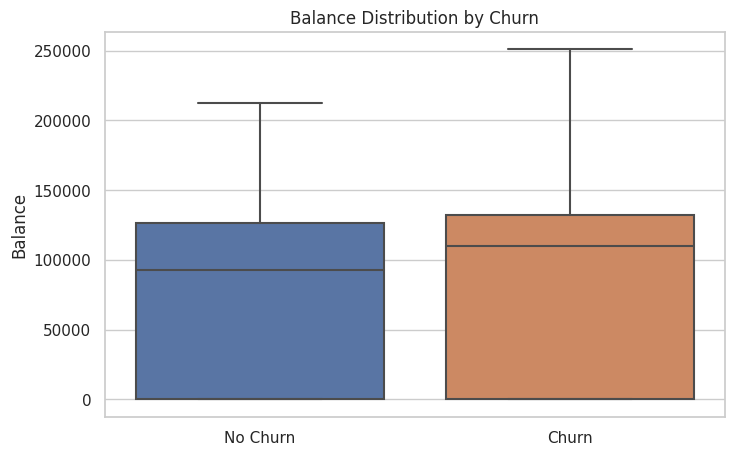

In [28]:
# 6. Feature: Balance vs Churn
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="Actual_Churn", y="Balance")
plt.title("Balance Distribution by Churn")
plt.xticks([0, 1], ['No Churn', 'Churn'])
plt.xlabel("")
plt.ylabel("Balance")
plt.show()